In [103]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyclustering.cluster.cure import cure

from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.clique import clique, clique_visualizer
from pyclustering.cluster.dbscan import dbscan

from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans;

from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES,FAMOUS_SAMPLES
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans, kmeans_observer, kmeans_visualizer

from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from pyclustering.utils.metric import distance_metric, type_metric
import matplotlib.pyplot as plt

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.birch import birch

from pyclustering.container.cftree import measurement_type

from pyclustering.utils import read_sample

from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES
from sklearn.metrics import accuracy_score

In [87]:
COMPARISION_DATASETS = ['LSUN','ENGYTIME','WINGNUT',"TETRA","ATOM"]


def get_y_pred(clusters):
    # Utitlity function that transforms the result of clustering into a sklearn friendly form 
    res = []
    y_pred=[]
    for pairs in  [[cluster_id,points] for cluster_id,points in enumerate(clusters,1)]:
        label = pairs[0]
        for p in pairs[1]:
            y_pred.append(label)
            res.append((p+1,label))
    return y_pred     

def get_y_true(name):
    return pd.read_csv('./FCPS/{}.cls'.format(name.upper()),sep='\t')['label'].to_list()


def get_data(name):

    X= read_sample(getattr(FCPS_SAMPLES,'SAMPLE_{}'.format(name)))
    y_true = pd.read_csv('./FCPS/{}.cls'.format(name),sep='\t')['label'].to_list()
    return X,y_true
    
        

'TwoDiamonds' - 0.985.
'WingNut' - 0.5.
'Hepta' - 0.9905660377358491.
'Tetra' - 1.0.
'Atom' - 1.0.
====== CURE ====== 


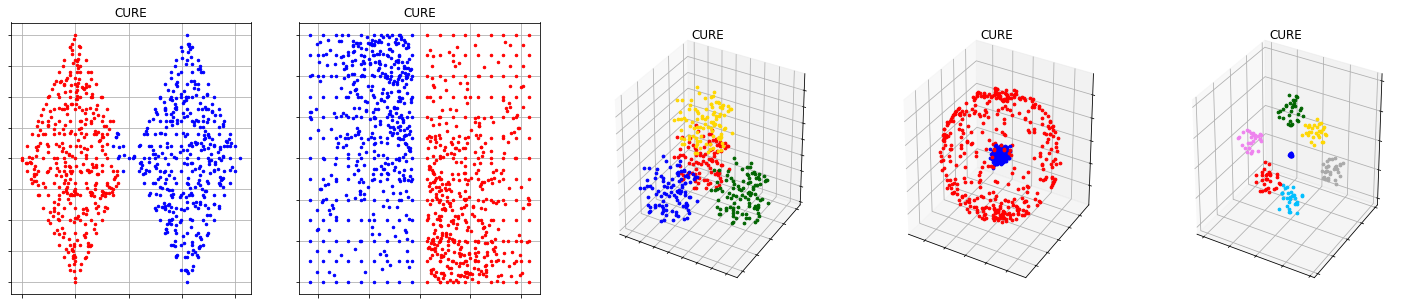

In [182]:
def cure_template_clustering(number_clusters, path, number_represent_points=5, compression=0.5, draw=False, ccore_flag=True):
    sample = read_sample(path)
    y_true=get_y_true(os.path.basename(path).split('.')[0])
    sample = sample[:len(y_true)]
    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)
    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    #accuracy_score(get_y_pred(os.path.basename(path).split('.')[0]),y_true)
    score = accuracy_score(get_y_pred(clusters),get_y_true(os.path.basename(path).split('.')[0]))
    print("'{}' - {}.".format(os.path.basename(path).split('.')[0],score))

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()
    return sample,clusters


def cluster_fcps():
    #lsun, lsun_clusters =  cure_template_clustering(3, FCPS_SAMPLES.SAMPLE_LSUN, 5, 0.3)
    #target, target_clusters = cure_template_clustering(6, FCPS_SAMPLES.SAMPLE_TARGET, 10, 0.3)
    two_diamonds, two_diamonds_clusters = cure_template_clustering(2, FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS, 10, 0.3)
    wing_nut, wing_nut_clusters =cure_template_clustering(2, FCPS_SAMPLES.SAMPLE_WING_NUT, 10, 0.3)
    
    hepta, hepta_clusters =     cure_template_clustering(7, FCPS_SAMPLES.SAMPLE_HEPTA, 10, 0.3)

    tetra, tetra_clusters =    cure_template_clustering(4, FCPS_SAMPLES.SAMPLE_TETRA,10,0.3)
    atom, atom_clusters =     cure_template_clustering(2, FCPS_SAMPLES.SAMPLE_ATOM, 10, 0.3)

    fig = plt.figure(figsize=(25, 5))
    print("====== {} ====== ".format("CURE"))
    
    visualizer = cluster_visualizer(5, 5,titles=['CURE','CURE','CURE','CURE','CURE'])
    #visualizer.append_clusters(target_clusters, target, 0)
    visualizer.append_clusters(two_diamonds_clusters, two_diamonds, 0)
    visualizer.append_clusters(wing_nut_clusters, wing_nut, 1)
    
    visualizer.append_clusters(tetra_clusters, tetra, 2)
    visualizer.append_clusters(atom_clusters, atom, 3)
    visualizer.append_clusters(hepta_clusters, hepta, 4)

    visualizer.show(figure=fig)    
    fig.savefig('./CURE.png')
    
cluster_fcps()

'Lsun' - 0.745.
'Target' - 0.0025974025974025974.
'TwoDiamonds' - 1.0.
'WingNut' - 0.5.
'Hepta' - 1.0.
'Tetra' - 0.85.
'Atom' - 0.9975.
====== DBSCAN ====== 


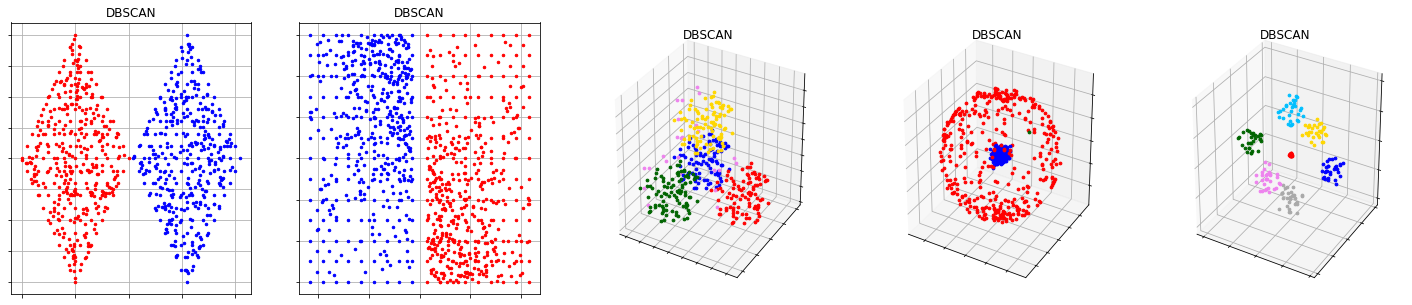

In [181]:
def DBSCAN_template_clustering(radius, neighb, path, invisible_axes = False, ccore = True, show = False):
    sample = read_sample(path)
    y_true=get_y_true(os.path.basename(path).split('.')[0])
    sample = sample[:len(y_true)]
    dbscan_instance = dbscan(sample, radius, neighb, ccore)
    (ticks, _) = timedcall(dbscan_instance.process)
    
    clusters = dbscan_instance.get_clusters()
    noise = dbscan_instance.get_noise()
    clusters.append(noise)
    #print([len(cluster) for cluster in clusters])
    score = accuracy_score(get_y_pred(clusters),get_y_true(os.path.basename(path).split('.')[0]))
    print("'{}' - {}.".format(os.path.basename(path).split('.')[0],score))
    if show:
        visualizer = cluster_visualizer()
        visualizer.append_clusters(clusters, sample)
        visualizer.append_cluster(noise, sample, marker = 'x')
        visualizer.show()
    
    #print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    
    return sample, clusters, noise

    
def display_fcps_clustering_results():
    (lsun, lsun_clusters, _) = DBSCAN_template_clustering(0.5, 3, FCPS_SAMPLES.SAMPLE_LSUN, False, True, False)
    (target, target_clusters, _) = DBSCAN_template_clustering(0.5, 2, FCPS_SAMPLES.SAMPLE_TARGET, False, True, False)
    (two_diamonds, two_diamonds_clusters, _) = DBSCAN_template_clustering(0.15, 7, FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS, False, True, False)
    (wing_nut, wing_nut_clusters, _) = DBSCAN_template_clustering(0.25, 2, FCPS_SAMPLES.SAMPLE_WING_NUT, False, True, False)
    #(chainlink, chainlink_clusters, _) = DBSCAN_template_clustering(0.5, 3, FCPS_SAMPLES.SAMPLE_CHAINLINK, False, True, False)
    (hepta, hepta_clusters, _) = DBSCAN_template_clustering(1, 3, FCPS_SAMPLES.SAMPLE_HEPTA, False, True, False)
    (tetra, tetra_clusters, tetra_noise) = DBSCAN_template_clustering(0.4, 3, FCPS_SAMPLES.SAMPLE_TETRA, False, True, False)
    (atom, atom_clusters, _) = DBSCAN_template_clustering(15, 3, FCPS_SAMPLES.SAMPLE_ATOM, False, True, False)
    
    fig = plt.figure(figsize=(25, 5))
    print("====== {} ====== ".format("DBSCAN"))
    
    visualizer = cluster_visualizer(5, 5,titles=["DBSCAN"]*10)
    #visualizer.append_clusters(target_clusters, target, 0)
    visualizer.append_clusters(two_diamonds_clusters, two_diamonds, 0)
    visualizer.append_clusters(wing_nut_clusters, wing_nut, 1)
    visualizer.append_clusters(tetra_clusters, tetra, 2)
    visualizer.append_clusters(atom_clusters, atom, 3)
    visualizer.append_clusters(hepta_clusters, hepta, 4)

    visualizer.show(figure=fig)
    fig.savefig('./DBSCAN.png')



display_fcps_clustering_results()

'TwoDiamonds' - 0.5.
'WingNut' - 0.5.
'Tetra' - 0.26.
'Atom' - 0.15875.
'Hepta' - 0.9528301886792453.
====== CLIQUE ====== 


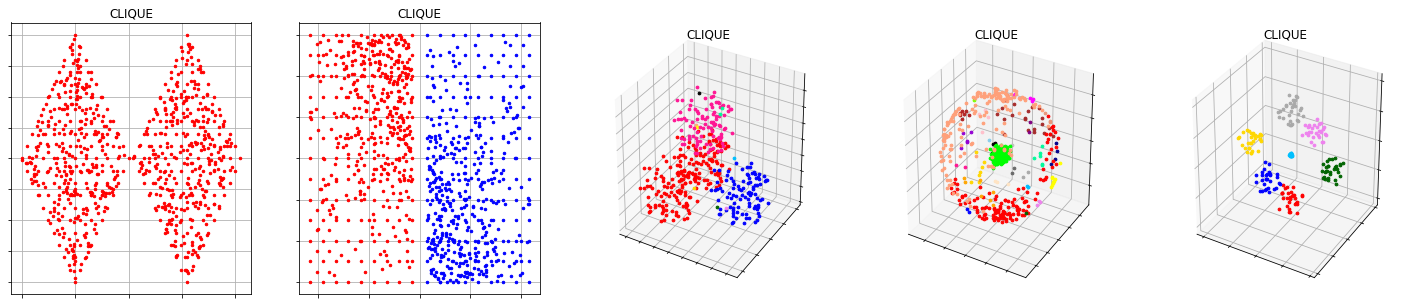

In [179]:


import pandas as pd
import matplotlib.pyplot as plt
import os

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.clique import clique, clique_visualizer

from pyclustering.utils import read_sample

from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES


def clique_template_clustering(data_path, intervals, density_threshold, **kwargs):
   # print("Sample: '%s'." % os.path.basename(data_path))
#
    data = read_sample(data_path)
    #print(len(data))
    y_true=get_y_true(os.path.basename(data_path).split('.')[0])
    
    data=data[:len(y_true)]
    clique_instance = clique(data, intervals, density_threshold)
    clique_instance.process()

    clusters = clique_instance.get_clusters()
    noise = clique_instance.get_noise()
    cells = clique_instance.get_cells()
    clusters.append(noise)

    y_pred=get_y_pred(clusters)
#    print(len(get_y_pred(clusters)),len(noise))
    score = accuracy_score(y_pred,y_true)
    print("'{}' - {}.".format(os.path.basename(data_path).split('.')[0],score))

    return data ,clusters
    #print([len(cluster) for cluster in clusters])

    #clique_visualizer.show_grid(cells, data)
    
    #visualizer = cluster_visualizer()
    #visualizer.append_clusters(clusters, data)
    #visualizer.append_cluster(noise, data, marker='x')
    #visualizer.show()



def cluster_fcps():
    #lsun, lsun_clusters =  clique_template_clustering(FCPS_SAMPLES.SAMPLE_LSUN, 15, 0)
    #target, target_clusters = clique_template_clustering(FCPS_SAMPLES.SAMPLE_TARGET, 10, 0)
    two_diamonds, two_diamonds_clusters = clique_template_clustering(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS, 10, 0)
    wing_nut, wing_nut_clusters =clique_template_clustering(FCPS_SAMPLES.SAMPLE_WING_NUT, 15, 0)
    #chainlink, chainlink_clusters =  clique_template_clustering(FCPS_SAMPLES.SAMPLE_CHAINLINK, 10, 0)

    tetra, tetra_clusters =    clique_template_clustering(FCPS_SAMPLES.SAMPLE_TETRA, 10, 0)
    atom, atom_clusters =     clique_template_clustering(FCPS_SAMPLES.SAMPLE_ATOM, 10, 0)
    hepta, hepta_clusters =     clique_template_clustering(FCPS_SAMPLES.SAMPLE_HEPTA, 9, 0)

    fig = plt.figure(figsize=(25, 5))
    print("====== {} ====== ".format("CLIQUE"))
    
    visualizer = cluster_visualizer(5, 5,titles=['CLIQUE']*5)
    #visualizer.append_clusters(target_clusters, target, 0)
    visualizer.append_clusters(two_diamonds_clusters, two_diamonds, 0)
    visualizer.append_clusters(wing_nut_clusters, wing_nut, 1)
    
    visualizer.append_clusters(tetra_clusters, tetra, 2)
    visualizer.append_clusters(atom_clusters, atom, 3)
    visualizer.append_clusters(hepta_clusters, hepta, 4)

    visualizer.show(figure=fig)    
    fig.savefig('./CLIQUE.png')

  
   



#cluster_simple_sample()
cluster_fcps()

'TwoDiamonds' - 0.99625.
'WingNut' - 0.5.
'Hepta' - 0.2830188679245283.
'Tetra' - 0.7125.
'Atom' - 0.6925.
====== KMeans ====== 


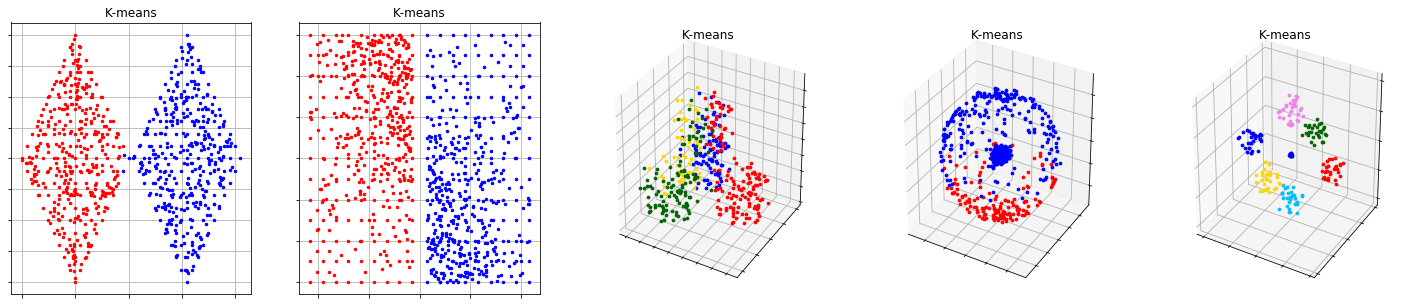

In [180]:
import random
import matplotlib.pyplot as plt


from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES, FAMOUS_SAMPLES

from pyclustering.cluster import cluster_visualizer,cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans, kmeans_observer, kmeans_visualizer

from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from pyclustering.utils.metric import distance_metric, type_metric


def kmeans_template_clustering(start_centers, path, tolerance = 0.25, ccore = False):
    sample = read_sample(path)
    dimension = len(sample[0])
    
    metric = distance_metric(type_metric.EUCLIDEAN)

    observer = kmeans_observer()
    kmeans_instance = kmeans(sample, start_centers, tolerance, ccore, observer=observer, metric=metric)
    (ticks, _) = timedcall(kmeans_instance.process)
    
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
  #  print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")

    y_pred=get_y_pred(clusters)
    y_true=get_y_true(os.path.basename(path).split('.')[0])

#    print(len(get_y_pred(clusters)),len(noise))
    score = accuracy_score(y_pred,y_true)
    print("'{}' - {}.".format(os.path.basename(path).split('.')[0],score))
    return sample, clusters
    
    


def kmeans_cluster_fcps(ccore = True):
    #lsun, lsun_clusters =               kmeans_template_clustering([[1.0, 3.5], [2.0, 0.5], [3.0, 3.0]], FCPS_SAMPLES.SAMPLE_LSUN, ccore)
    #target, target_clusters =           kmeans_template_clustering([[0.2, 0.2], [0.0, -2.0], [3.0, -3.0], [3.0, 3.0], [-3.0, 3.0], [-3.0, -3.0]], FCPS_SAMPLES.SAMPLE_TARGET, ccore)
    two_diamonds, two_diamonds_clusters=kmeans_template_clustering([[0.8, 0.2], [3.0, 0.0]], FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS, ccore)
    wing_nut, wing_nut_clusters =       kmeans_template_clustering([[-1.5, 1.5], [1.5, 1.5]], FCPS_SAMPLES.SAMPLE_WING_NUT, ccore)
    #chainlink, chainlink_clusters =     kmeans_template_clustering([[1.1, -1.7, 1.1], [-1.4, 2.5, -1.2]], FCPS_SAMPLES.SAMPLE_CHAINLINK, ccore)
    hepta, hepta_clusters =             kmeans_template_clustering([[1.0, 2.0, 3.0], [3.0, 0.0, 0.0], [-2.0, 0.0, 0.0], [0.0, 3.0, 0.0], [0.0, -3.0, 0.0], [0.0, 0.0, 2.5], [0.0, 0.0, -2.5]], FCPS_SAMPLES.SAMPLE_HEPTA, ccore)
    tetra, tetra_clusters =             kmeans_template_clustering([[1, 0, 0], [0, 1, 0], [0, -1, 0], [-1, 0, 0]], FCPS_SAMPLES.SAMPLE_TETRA, ccore)
    atom, atom_clusters =               kmeans_template_clustering([[-0.5, -0.5, -0.5], [0.5, 0.5, 0.5]], FCPS_SAMPLES.SAMPLE_ATOM, ccore)
    #kmeans_template_clustering([[0.5, 0.5], [2.3, 2.9]], FCPS_SAMPLES.SAMPLE_ENGY_TIME, ccore)
    

    fig = plt.figure(figsize=(25, 5))
    print("====== {} ====== ".format("KMeans"))
    
    visualizer = cluster_visualizer(5, 5,titles=['K-means']*5)
    #visualizer.append_clusters(target_clusters, target, 0)
    visualizer.append_clusters(two_diamonds_clusters, two_diamonds, 0)
    visualizer.append_clusters(wing_nut_clusters, wing_nut, 1)
    
    visualizer.append_clusters(tetra_clusters, tetra, 2)
    visualizer.append_clusters(atom_clusters, atom, 3)
    visualizer.append_clusters(hepta_clusters, hepta, 4)

    visualizer.show(figure=fig) 
    fig.savefig('./KMeans.png')
    
def clustering_random_points(amount_points, amount_centers, ccore):
    sample = [ [ random.random(), random.random() ] for _ in range(amount_points) ]
    centers = [ [ random.random(), random.random() ] for _ in range(amount_centers) ]
    
    kmeans_instance = kmeans(sample, centers, 0.0001, ccore)
    (ticks, _) = timedcall(kmeans_instance.process)
    
    print("Execution time ("+ str(amount_points) +" 2D-points):", ticks)

kmeans_cluster_fcps()